Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3266.94draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(500, 3)
(3,)
测试集准确率：1.000000


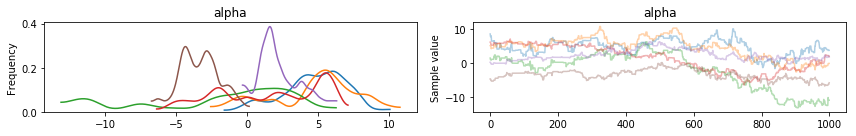

In [2]:
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import matplotlib.pyplot as plt

# Loading the Iris dataset
X, y = datasets.load_iris(True)
X_input = theano.shared(X)#转numpy array
Y_output = theano.shared(y)#转numpy array
with pm.Model() as iris_model:
    # Creating the model
    beta = pm.Normal('beta', mu=0, sd=10, shape=(4,3))
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=3)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    obs = pm.Categorical('obs', p=p, observed=Y_output)
        
    step = pm.Metropolis()
    trace = pm.sample(1000,step=step,chains=2,cores=2)
    pm.traceplot(trace, varnames=['alpha'])
    #pm.summary(trace, varnames=['alpha'])
    #plt.show()
    #print (trace['alpha'].shape)#<class 'numpy.ndarray'>
    #print (type(obs))
    #print (type(beta))
    
X_input.set_value(X[[0, 1, 2], :])#转numpy array
Y_output.set_value(y[0:3])
with iris_model:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False) 
    print(ppc['obs'].shape)
    pred = ppc['obs'].mean(axis=0)
    print(pred.shape)
print ('测试集准确率：%f'% accuracy_score(y[0:3], pred.round()))

In [ ]:
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
start = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathV.csv",sep='|',low_memory=False) 
data = data.fillna(0)#填补空值为零
#data = data.dropna(axis=0,how='any')
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = pm.Minibatch(X_train.values, batch_size=10000)
Y_output = pm.Minibatch(Y_train.values, batch_size=10000)
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=10, shape=(3584,6))
    alpha = pm.Normal('alfa', mu=0, sd=10, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    step = pm.NUTS()#step = pm.Metropolis()
    trace = pm.sample(1000,step=step)#4chains
    pm.traceplot(trace)
#5.ppc预测
X_input.set_value(X_test.values[0:10000])#测试集
Y_output.set_value(Y_test.values[0:10000])#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False) 
    Y_pred = ppc['Y_obs'].mean(axis=0)
print ('测试集准确率：%f'% accuracy_score(Y_test, Y_pred))
end = time.time()
print ("Complete time: %f s" % (end - start))

(542340, 3586)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta]
Sampling 4 chains:   0%|          | 20/6000 [12:50:15<4701:39:26, 2830.43s/draws] 

In [14]:
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathV.csv",sep='|',low_memory=False)#,iterator=True) 
#data = data.get_chunk(10000)
data = data.fillna(0)#填补空值为零
#data = data.dropna(axis=0,how='any')
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=10, shape=(3584,6))
    alpha = pm.Normal('alfa', mu=0, sd=10, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    start=pm.find_MAP()  # 参数初猜
    step = pm.Metropolis()#多分类采样#step = pm.NUTS()连续采样
    trace = pm.sample(1000,start=start,step=step,chains=2,cores=8)
    #pm.traceplot(trace)
X_input.set_value(X_test.values)#测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(542340, 3586)


logp = -2.2291e+05, ||grad|| = 12.252: 100%|██████████| 3051/3051 [17:47:31<00:00, 20.99s/it]   
Multiprocess sampling (2 chains in 8 jobs)
CompoundStep
>Metropolis: [alfa]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [12:33:46<00:00, 14.74s/draws]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 2000/2000 [4:34:54<00:00,  7.72s/it]  


测试集准确率：0.836984
Complete time: 127367.601532 s
